### Data Loading And shortening..

In [ ]:
# Data Fetching as Pandas.DataFrame
import pandas as pd
import warnings
warnings.filterwarnings('ignore') 

xslfile = 'The11poets_Yemenies_Poems.xlsx'
y_poems = pd.read_excel(xslfile, index_col=0)
y_poems.head(2)

,pname,pid,ptitle,verses,rootedvs
0,عبدالله البردوني,1,ابو تمام و عروبة اليوم,أصدق السيف ينضه الكذب أكذب السيف يصدق الغضب يض...,صدق سيف نضض كذب كذب سيف صدق غضب ض صفءح هدد حمل...
10,عبدالله البردوني,1,من أرض بلقيس,أرض بلقيس اللحن والوتر جوها الأنسام والسحر صدر...,رضض لقس لحح وتر جوه نسم سحر صدر آهو مهه لحح تر...


In [2]:
print(y_poems.shape, y_poems.isna().sum().sum(), y_poems.columns, y_poems.pid.unique().shape)
verses_count = y_poems.groupby('pname')['verses'].count()
rverses_count = y_poems.groupby('pname')['rootedvs'].count()
pd.concat([verses_count, rverses_count], axis=1).reset_index()

(1197, 5) 0 Index(['pname', 'pid', 'ptitle', 'verses', 'rootedvs'], dtype='object') (11,)


,pname,verses,rootedvs
0,إبراهيم الحضرمي,16,16
1,حسن عبدالله الكاف,69,69
2,عبدالحكيم الفقيه,107,107
3,عبدالسلام الكبسي,98,98
4,عبدالعزيز المقالح,60,60
5,عبدالله البردوني,334,334
6,عبدالله عبدالوهاب نعمان,68,68
7,عمارة اليمني,40,40
8,محمد محمود الزبيري,41,41
9,هناء محمد,147,147


# Feature Extraction Methods

In [3]:
from gensim.models import Word2Vec, Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np
import multiprocessing

def prepare_features(texts, labels, w2v_size = 200, d2v_size= 400, max_len = 200, test_size= 0.3):

    le = LabelEncoder()
    y = le.fit_transform(labels)
    num_classes = len(le.classes_)
    
    X_train, X_test, y_train, y_test = train_test_split(texts, y, test_size=test_size)
    
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(X_train)
    vocab_size = len(tokenizer.word_index) + 1
    
    X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=max_len)
    X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_len)
    
    cpu_cores = multiprocessing.cpu_count()
    
    sentences = [text.split() for text in X_train]
    w2v_model = Word2Vec(sentences, vector_size = w2v_size, window=5, min_count=1, workers= cpu_cores, sg = 1, epochs=30)
    w2v_matrix = np.zeros((vocab_size, w2v_size))
    for word, i in tokenizer.word_index.items():
        if word in w2v_model.wv: w2v_matrix[i] = w2v_model.wv[word]

    tagged_data = [TaggedDocument(words=text.split(), tags=[str(i)]) for i, text in enumerate(X_train)]
    d2v_model = Doc2Vec(tagged_data, vector_size=d2v_size, window=5, min_count=2, workers= cpu_cores, epochs=30)
    d2v_model.build_vocab(tagged_data)
    d2v_model.train(tagged_data, total_examples= d2v_model.corpus_count, epochs= d2v_model.epochs)
    
    def get_d2v(texts): return np.array([d2v_model.infer_vector(text.split()) for text in texts])
    X_train_d2v = get_d2v(X_train)
    X_test_d2v = get_d2v(X_test)
    
    return {
        'X_train_seq': X_train_seq,
        'X_test_seq': X_test_seq,
        'X_train_d2v': X_train_d2v,
        'X_test_d2v': X_test_d2v,
        'y_train': y_train,
        'y_test': y_test,
        'tokenizer': tokenizer,
        'w2v_model': w2v_model,
        'd2v_model': d2v_model,
        'label_encoder': le,
        'w2v_matrix': w2v_matrix,
        'vocab_size': vocab_size,
        'num_classes': num_classes,
        'max_len': max_len}

## Models, layers, training, and testing ..

In [5]:
# Functions of embdding layer with w2v, and both two models process, arriving ot the accuracy of testing phase...
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, SimpleRNN, Dense, Embedding, Concatenate, LSTM, Bidirectional
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

adam_optm = Adam()
rmsp_optm = RMSprop()

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

def rnn_train_model(features, rnn_units = 128, epochs= 30, dropout_rate = 0.5, bsize = 64, isadam = True):
    input_layer = Input(shape=(features['max_len'],))
    w2v_embedding = Embedding(features['vocab_size'], features['w2v_matrix'].shape[1], weights=[features['w2v_matrix']], 
                        input_length=features['max_len'], trainable=False)(input_layer)
    lstm_layer = Bidirectional(LSTM(rnn_units))(w2v_embedding)
    d2v_input = Input(shape=(features['d2v_model'].vector_size,))
    combined = Concatenate()([lstm_layer, d2v_input])
    dropout = Dropout(dropout_rate)(combined)
    output = Dense(features['num_classes'], activation='softmax')(dropout)
    model = Model(inputs=[input_layer, d2v_input], outputs=output)
    
    model.compile(optimizer= adam_optm if isadam else rmsp_optm, loss='sparse_categorical_crossentropy', metrics=['accuracy'])    
    history = model.fit([features['X_train_seq'], features['X_train_d2v']], features['y_train'],
        validation_data=([features['X_test_seq'], features['X_test_d2v']], features['y_test']), epochs=epochs, 
        callbacks=[early_stopping], batch_size = bsize, verbose = 2)
    return model, history

def cnn_train_model(features, filters= 128, epochs= 30, dropout_rate=0.5, bsize = 64, isadam = True):    
    input_layer = Input(shape=(features['max_len'],))
    w2v_embedding = Embedding(features['vocab_size'], features['w2v_matrix'].shape[1], weights=[features['w2v_matrix']], 
                           input_length=features['max_len'], trainable=False)(input_layer)
    conv1 = Conv1D(filters, 3, activation='relu')(w2v_embedding)
    pool1 = GlobalMaxPooling1D()(conv1)
    conv2 = Conv1D(128, 4, activation='relu')(w2v_embedding)
    pool2 = GlobalMaxPooling1D()(conv2)
    conv3 = Conv1D(128, 5, activation='relu')(w2v_embedding)
    pool3 = GlobalMaxPooling1D()(conv3)
    text_features = Concatenate()([pool1, pool2, pool3])
    d2v_input = Input(shape=(features['d2v_model'].vector_size,))
    combined = Concatenate()([text_features, d2v_input])
    dropout = Dropout(dropout_rate)(combined)
    output = Dense(features['num_classes'], activation='softmax')(dropout)

    model = Model(inputs=[input_layer, d2v_input], outputs=output)
    model.compile(optimizer= adam_optm if isadam else rmsp_optm, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    history = model.fit([features['X_train_seq'], features['X_train_d2v']], features['y_train'], 
        validation_data=([features['X_test_seq'], features['X_test_d2v']], features['y_test']), epochs=epochs, 
        callbacks=[early_stopping], batch_size = bsize, verbose = 2)
    return model, history
#hists = lambda hst: pd.DataFrame(hst.history).iloc[-1,:].tolist()
def hists(hst):
    df = pd.DataFrame(hst.history)
    lst = df.iloc[-1,:].tolist()
    lst.append(df.shape[0])
    return lst

def plotting_train_val(history):    
    # Extract metrics from the history object
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(1, len(train_acc) + 1)
    # Plot Accuracy
    plt.figure(figsize=(10, 3))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()
    return hists(history)

In [6]:
# Feature splitting, embedding and extaction ..
texts = y_poems.rootedvs
labels =  y_poems.pname
exp_res = [] 
features = prepare_features(texts, labels)
#54.7s

Epoch 1/30
14/14 - 4s - 270ms/step - accuracy: 0.2593 - loss: 2.4428 - val_accuracy: 0.3806 - val_loss: 1.8189
Epoch 2/30
14/14 - 2s - 130ms/step - accuracy: 0.4397 - loss: 1.7145 - val_accuracy: 0.5222 - val_loss: 1.4965
Epoch 3/30
14/14 - 2s - 131ms/step - accuracy: 0.5759 - loss: 1.3205 - val_accuracy: 0.6306 - val_loss: 1.3170
Epoch 4/30
14/14 - 2s - 133ms/step - accuracy: 0.7109 - loss: 1.0161 - val_accuracy: 0.6278 - val_loss: 1.2042
Epoch 5/30
14/14 - 2s - 125ms/step - accuracy: 0.7778 - loss: 0.8246 - val_accuracy: 0.7556 - val_loss: 1.0809
Epoch 6/30
14/14 - 2s - 127ms/step - accuracy: 0.8769 - loss: 0.6488 - val_accuracy: 0.7583 - val_loss: 1.0087
Epoch 7/30
14/14 - 2s - 123ms/step - accuracy: 0.9020 - loss: 0.5627 - val_accuracy: 0.7694 - val_loss: 0.9618
Epoch 8/30
14/14 - 2s - 124ms/step - accuracy: 0.9307 - loss: 0.4703 - val_accuracy: 0.7917 - val_loss: 0.9144
Epoch 9/30
14/14 - 2s - 129ms/step - accuracy: 0.9450 - loss: 0.4128 - val_accuracy: 0.8278 - val_loss: 0.8549
E

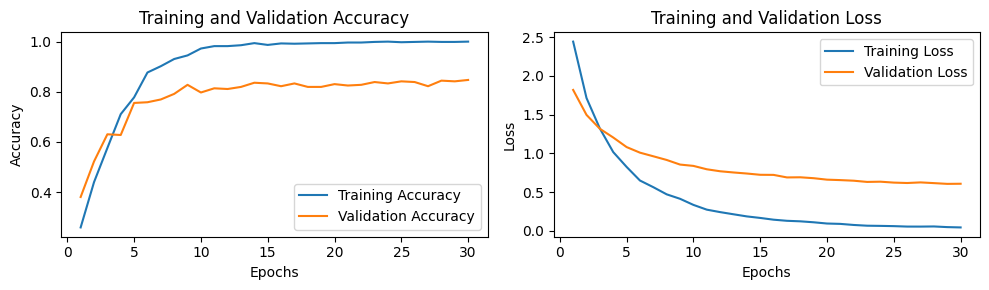

In [7]:
adam_optm = Adam()
mdl1, hist1 = cnn_train_model(features)
exp_res.append(plotting_train_val(hist1))
#41.0s

Epoch 1/30
14/14 - 8s - 542ms/step - accuracy: 0.1828 - loss: 2.3748 - val_accuracy: 0.3444 - val_loss: 1.9311
Epoch 2/30
14/14 - 4s - 297ms/step - accuracy: 0.3489 - loss: 1.8841 - val_accuracy: 0.4639 - val_loss: 1.6702
Epoch 3/30
14/14 - 4s - 306ms/step - accuracy: 0.4612 - loss: 1.5969 - val_accuracy: 0.5861 - val_loss: 1.4403
Epoch 4/30
14/14 - 5s - 330ms/step - accuracy: 0.5149 - loss: 1.4786 - val_accuracy: 0.6389 - val_loss: 1.3549
Epoch 5/30
14/14 - 5s - 354ms/step - accuracy: 0.5998 - loss: 1.2444 - val_accuracy: 0.5694 - val_loss: 1.2880
Epoch 6/30
14/14 - 5s - 357ms/step - accuracy: 0.6679 - loss: 1.0921 - val_accuracy: 0.7167 - val_loss: 1.0245
Epoch 7/30
14/14 - 5s - 357ms/step - accuracy: 0.7443 - loss: 0.9236 - val_accuracy: 0.7306 - val_loss: 0.9560
Epoch 8/30
14/14 - 5s - 370ms/step - accuracy: 0.7563 - loss: 0.7773 - val_accuracy: 0.7222 - val_loss: 0.8992
Epoch 9/30
14/14 - 5s - 358ms/step - accuracy: 0.7981 - loss: 0.7148 - val_accuracy: 0.7667 - val_loss: 0.7912
E

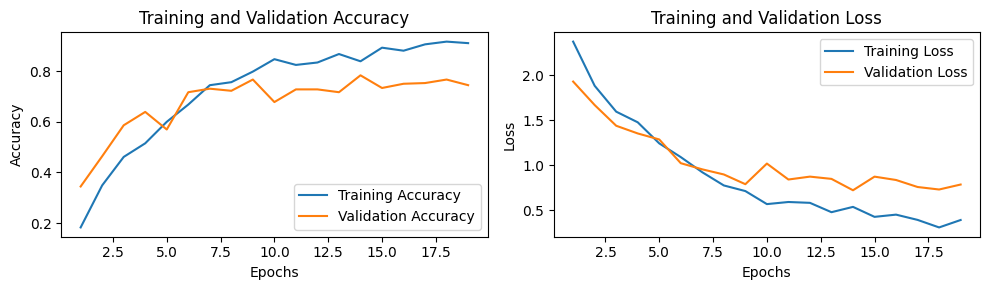

In [8]:
adam_optm = Adam()
mdl2, hist2 = rnn_train_model(features)
exp_res.append(plotting_train_val(hist2))
#

### Updating some of CNN and RNN hyperMeters

#### updating learning rate from default 0.001 to 0.0001, then 0.0005

Epoch 1/30
14/14 - 3s - 234ms/step - accuracy: 0.1195 - loss: 2.8847 - val_accuracy: 0.2556 - val_loss: 2.2047
Epoch 2/30
14/14 - 2s - 125ms/step - accuracy: 0.1888 - loss: 2.5740 - val_accuracy: 0.2639 - val_loss: 2.1341
Epoch 3/30
14/14 - 2s - 125ms/step - accuracy: 0.1959 - loss: 2.4395 - val_accuracy: 0.2667 - val_loss: 2.0976
Epoch 4/30
14/14 - 2s - 125ms/step - accuracy: 0.2306 - loss: 2.3985 - val_accuracy: 0.2833 - val_loss: 2.0602
Epoch 5/30
14/14 - 2s - 121ms/step - accuracy: 0.2246 - loss: 2.3474 - val_accuracy: 0.2972 - val_loss: 2.0173
Epoch 6/30
14/14 - 2s - 120ms/step - accuracy: 0.2521 - loss: 2.3018 - val_accuracy: 0.3139 - val_loss: 1.9832
Epoch 7/30
14/14 - 2s - 123ms/step - accuracy: 0.2569 - loss: 2.1812 - val_accuracy: 0.3194 - val_loss: 1.9496
Epoch 8/30
14/14 - 2s - 125ms/step - accuracy: 0.2700 - loss: 2.1716 - val_accuracy: 0.3222 - val_loss: 1.9218
Epoch 9/30
14/14 - 2s - 124ms/step - accuracy: 0.3011 - loss: 2.0549 - val_accuracy: 0.3278 - val_loss: 1.8874
E

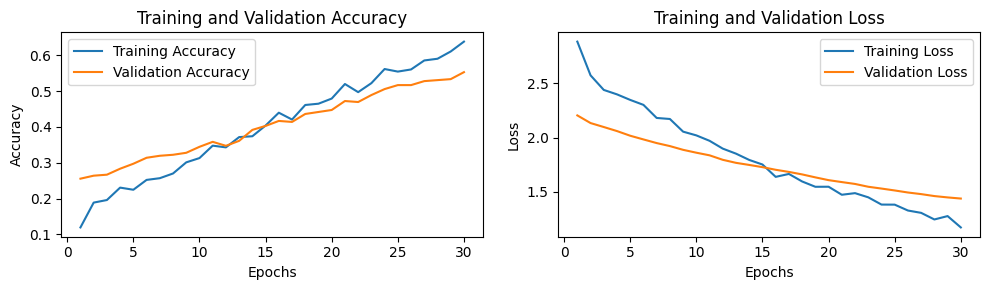

In [9]:
adam_optm = Adam(learning_rate=0.0001)
mdl1, hist1 = cnn_train_model(features)
exp_res.append(plotting_train_val(hist1))
#

Epoch 1/30
14/14 - 8s - 606ms/step - accuracy: 0.1039 - loss: 2.6650 - val_accuracy: 0.1556 - val_loss: 2.4254
Epoch 2/30
14/14 - 5s - 370ms/step - accuracy: 0.1254 - loss: 2.5492 - val_accuracy: 0.1861 - val_loss: 2.3379
Epoch 3/30
14/14 - 5s - 370ms/step - accuracy: 0.1720 - loss: 2.4086 - val_accuracy: 0.2111 - val_loss: 2.2481
Epoch 4/30
14/14 - 5s - 377ms/step - accuracy: 0.1673 - loss: 2.3934 - val_accuracy: 0.2583 - val_loss: 2.1604
Epoch 5/30
14/14 - 5s - 380ms/step - accuracy: 0.1983 - loss: 2.2620 - val_accuracy: 0.2806 - val_loss: 2.0843
Epoch 6/30
14/14 - 5s - 377ms/step - accuracy: 0.2354 - loss: 2.2002 - val_accuracy: 0.2778 - val_loss: 2.0369
Epoch 7/30
14/14 - 5s - 376ms/step - accuracy: 0.2354 - loss: 2.1446 - val_accuracy: 0.2833 - val_loss: 1.9975
Epoch 8/30
14/14 - 6s - 401ms/step - accuracy: 0.2664 - loss: 2.1183 - val_accuracy: 0.3056 - val_loss: 1.9471
Epoch 9/30
14/14 - 6s - 405ms/step - accuracy: 0.2987 - loss: 2.0355 - val_accuracy: 0.3139 - val_loss: 1.9074
E

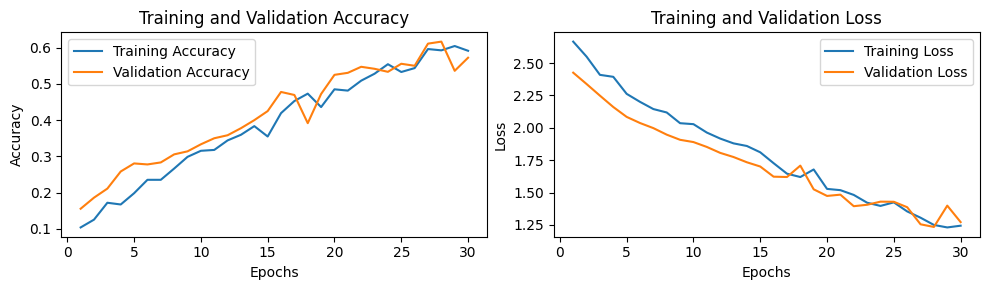

In [10]:
adam_optm = Adam(learning_rate=0.0001)
mdl2, hist2 = rnn_train_model(features)
exp_res.append(plotting_train_val(hist2))
#

Epoch 1/30
14/14 - 4s - 254ms/step - accuracy: 0.1732 - loss: 2.7585 - val_accuracy: 0.2750 - val_loss: 2.1525
Epoch 2/30
14/14 - 2s - 135ms/step - accuracy: 0.2378 - loss: 2.3193 - val_accuracy: 0.3333 - val_loss: 1.9141
Epoch 3/30
14/14 - 2s - 136ms/step - accuracy: 0.3548 - loss: 1.8943 - val_accuracy: 0.3889 - val_loss: 1.7485
Epoch 4/30
14/14 - 2s - 152ms/step - accuracy: 0.4648 - loss: 1.6309 - val_accuracy: 0.4389 - val_loss: 1.6151
Epoch 5/30
14/14 - 2s - 134ms/step - accuracy: 0.5352 - loss: 1.4366 - val_accuracy: 0.5500 - val_loss: 1.5203
Epoch 6/30
14/14 - 2s - 135ms/step - accuracy: 0.5890 - loss: 1.3061 - val_accuracy: 0.5694 - val_loss: 1.4168
Epoch 7/30
14/14 - 2s - 123ms/step - accuracy: 0.6667 - loss: 1.1359 - val_accuracy: 0.6361 - val_loss: 1.3221
Epoch 8/30
14/14 - 2s - 123ms/step - accuracy: 0.7264 - loss: 1.0189 - val_accuracy: 0.6361 - val_loss: 1.2527
Epoch 9/30
14/14 - 2s - 124ms/step - accuracy: 0.7611 - loss: 0.9146 - val_accuracy: 0.6722 - val_loss: 1.2037
E

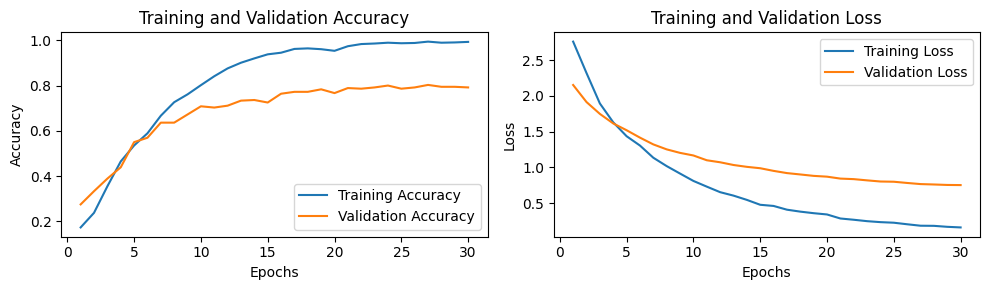

In [11]:
adam_optm = Adam(learning_rate=0.0005)
mdl1, hist1 = cnn_train_model(features)
exp_res.append(plotting_train_val(hist1))
#

Epoch 1/30
14/14 - 9s - 635ms/step - accuracy: 0.1207 - loss: 2.5164 - val_accuracy: 0.3194 - val_loss: 2.0212
Epoch 2/30
14/14 - 5s - 388ms/step - accuracy: 0.2593 - loss: 2.1106 - val_accuracy: 0.3528 - val_loss: 1.8539
Epoch 3/30
14/14 - 5s - 352ms/step - accuracy: 0.3130 - loss: 1.9505 - val_accuracy: 0.3917 - val_loss: 1.7409
Epoch 4/30
14/14 - 5s - 346ms/step - accuracy: 0.3668 - loss: 1.7530 - val_accuracy: 0.4556 - val_loss: 1.6096
Epoch 5/30
14/14 - 5s - 361ms/step - accuracy: 0.4409 - loss: 1.6158 - val_accuracy: 0.5417 - val_loss: 1.4297
Epoch 6/30
14/14 - 5s - 329ms/step - accuracy: 0.5090 - loss: 1.4504 - val_accuracy: 0.5194 - val_loss: 1.4161
Epoch 7/30
14/14 - 4s - 316ms/step - accuracy: 0.5460 - loss: 1.3859 - val_accuracy: 0.5722 - val_loss: 1.3171
Epoch 8/30
14/14 - 5s - 335ms/step - accuracy: 0.5866 - loss: 1.2705 - val_accuracy: 0.6306 - val_loss: 1.3252
Epoch 9/30
14/14 - 5s - 326ms/step - accuracy: 0.6093 - loss: 1.1885 - val_accuracy: 0.6472 - val_loss: 1.1314
E

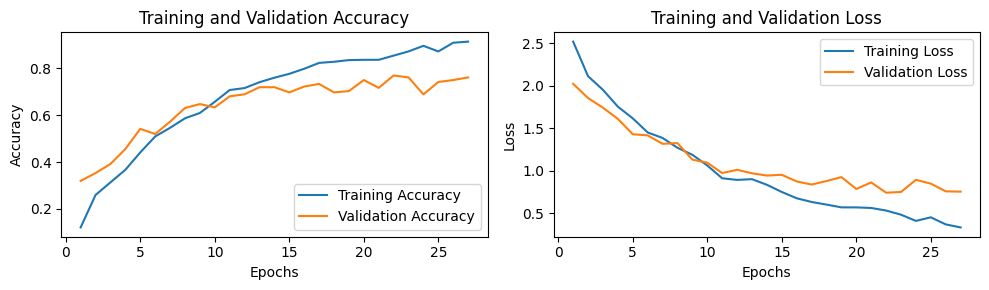

In [12]:
adam_optm = Adam(learning_rate=0.0005)
mdl2, hist2 = rnn_train_model(features)
exp_res.append(plotting_train_val(hist2))
#

####

#### Optimizer

Epoch 1/30
14/14 - 3s - 208ms/step - accuracy: 0.2413 - loss: 2.4766 - val_accuracy: 0.1528 - val_loss: 2.3101
Epoch 2/30
14/14 - 2s - 130ms/step - accuracy: 0.4504 - loss: 1.6253 - val_accuracy: 0.4583 - val_loss: 1.5284
Epoch 3/30
14/14 - 2s - 128ms/step - accuracy: 0.6237 - loss: 1.2278 - val_accuracy: 0.6250 - val_loss: 1.3229
Epoch 4/30
14/14 - 2s - 123ms/step - accuracy: 0.7443 - loss: 0.9452 - val_accuracy: 0.6500 - val_loss: 1.2040
Epoch 5/30
14/14 - 2s - 128ms/step - accuracy: 0.8148 - loss: 0.7822 - val_accuracy: 0.6722 - val_loss: 1.1018
Epoch 6/30
14/14 - 2s - 128ms/step - accuracy: 0.8996 - loss: 0.5687 - val_accuracy: 0.5833 - val_loss: 1.1724
Epoch 7/30
14/14 - 2s - 137ms/step - accuracy: 0.9271 - loss: 0.4929 - val_accuracy: 0.7389 - val_loss: 0.9495
Epoch 8/30
14/14 - 2s - 127ms/step - accuracy: 0.9582 - loss: 0.3698 - val_accuracy: 0.7167 - val_loss: 0.9284
Epoch 9/30
14/14 - 2s - 126ms/step - accuracy: 0.9665 - loss: 0.2978 - val_accuracy: 0.7167 - val_loss: 0.9022
E

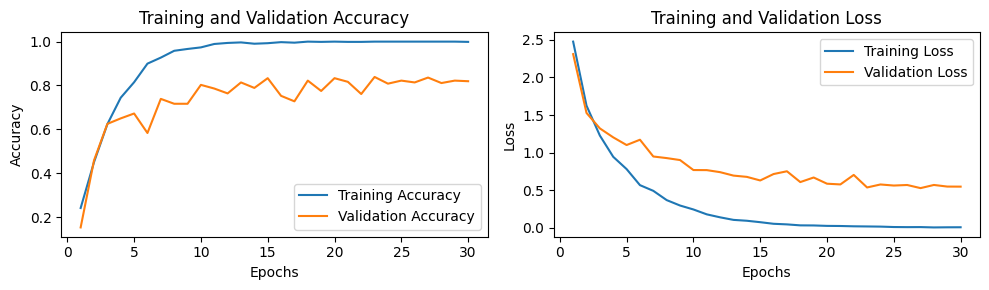

In [13]:
rmsp_optm = RMSprop()
mdl1, hist1 = cnn_train_model(features, isadam=False)
exp_res.append(plotting_train_val(hist1))
#

Epoch 1/30
14/14 - 8s - 558ms/step - accuracy: 0.2963 - loss: 2.1132 - val_accuracy: 0.4528 - val_loss: 1.7107
Epoch 2/30
14/14 - 5s - 360ms/step - accuracy: 0.4110 - loss: 1.7185 - val_accuracy: 0.5806 - val_loss: 1.4949
Epoch 3/30
14/14 - 5s - 387ms/step - accuracy: 0.4875 - loss: 1.5358 - val_accuracy: 0.5556 - val_loss: 1.3289
Epoch 4/30
14/14 - 5s - 392ms/step - accuracy: 0.5830 - loss: 1.2712 - val_accuracy: 0.6528 - val_loss: 1.2742
Epoch 5/30
14/14 - 5s - 383ms/step - accuracy: 0.6703 - loss: 1.0895 - val_accuracy: 0.6306 - val_loss: 1.2022
Epoch 6/30
14/14 - 5s - 386ms/step - accuracy: 0.6953 - loss: 0.9873 - val_accuracy: 0.5833 - val_loss: 1.1411
Epoch 7/30
14/14 - 5s - 383ms/step - accuracy: 0.7288 - loss: 0.9021 - val_accuracy: 0.5722 - val_loss: 1.2625
Epoch 8/30
14/14 - 6s - 401ms/step - accuracy: 0.7587 - loss: 0.8301 - val_accuracy: 0.6944 - val_loss: 0.9473
Epoch 9/30
14/14 - 6s - 439ms/step - accuracy: 0.7861 - loss: 0.7137 - val_accuracy: 0.7778 - val_loss: 0.8048
E

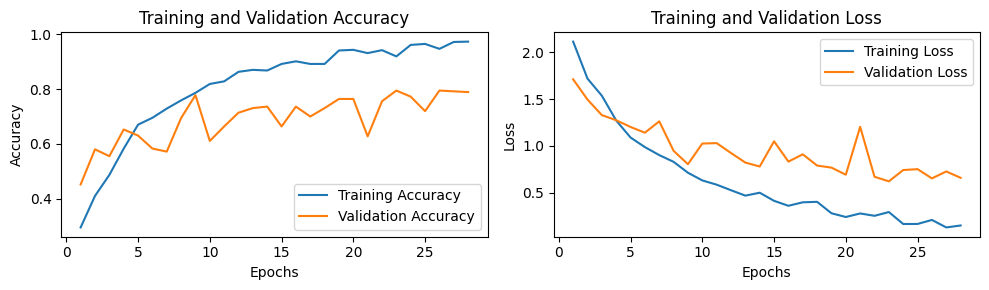

In [14]:
rmsp_optm = RMSprop()
mdl2, hist2 = rnn_train_model(features, isadam=False)
exp_res.append(plotting_train_val(hist2))
#47.1s

Epoch 1/30
14/14 - 3s - 239ms/step - accuracy: 0.2031 - loss: 2.5314 - val_accuracy: 0.3139 - val_loss: 1.9725
Epoch 2/30
14/14 - 2s - 124ms/step - accuracy: 0.3142 - loss: 2.0652 - val_accuracy: 0.3556 - val_loss: 1.8364
Epoch 3/30
14/14 - 2s - 124ms/step - accuracy: 0.3943 - loss: 1.7858 - val_accuracy: 0.4167 - val_loss: 1.6680
Epoch 4/30
14/14 - 2s - 125ms/step - accuracy: 0.4767 - loss: 1.5679 - val_accuracy: 0.4222 - val_loss: 1.6692
Epoch 5/30
14/14 - 2s - 125ms/step - accuracy: 0.5675 - loss: 1.3716 - val_accuracy: 0.5028 - val_loss: 1.5007
Epoch 6/30
14/14 - 2s - 121ms/step - accuracy: 0.6392 - loss: 1.1586 - val_accuracy: 0.6417 - val_loss: 1.3990
Epoch 7/30
14/14 - 2s - 131ms/step - accuracy: 0.7312 - loss: 1.0208 - val_accuracy: 0.5250 - val_loss: 1.3790
Epoch 8/30
14/14 - 2s - 130ms/step - accuracy: 0.7587 - loss: 0.9400 - val_accuracy: 0.6111 - val_loss: 1.2640
Epoch 9/30
14/14 - 2s - 125ms/step - accuracy: 0.8280 - loss: 0.7986 - val_accuracy: 0.6194 - val_loss: 1.2162
E

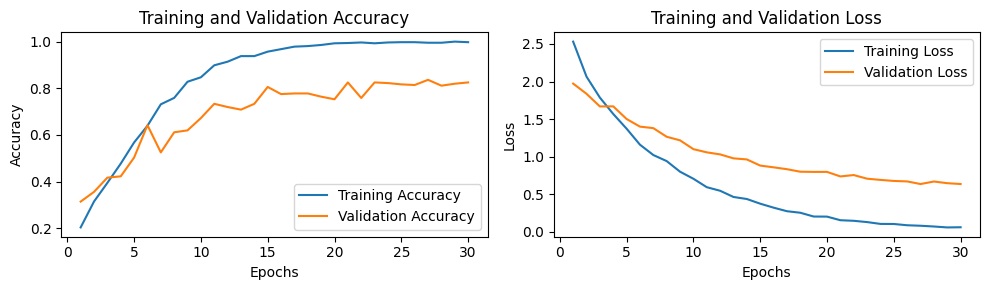

In [15]:
rmsp_optm = RMSprop(learning_rate= 0.0005)
mdl1, hist1 = cnn_train_model(features, isadam = False)
exp_res.append(plotting_train_val(hist1))
#

Epoch 1/30
14/14 - 9s - 609ms/step - accuracy: 0.1649 - loss: 2.4464 - val_accuracy: 0.3167 - val_loss: 2.0573
Epoch 2/30
14/14 - 5s - 381ms/step - accuracy: 0.2808 - loss: 2.0906 - val_accuracy: 0.3417 - val_loss: 1.8802
Epoch 3/30
14/14 - 5s - 370ms/step - accuracy: 0.3238 - loss: 1.9329 - val_accuracy: 0.4389 - val_loss: 1.7737
Epoch 4/30
14/14 - 5s - 364ms/step - accuracy: 0.4229 - loss: 1.7668 - val_accuracy: 0.4167 - val_loss: 1.7472
Epoch 5/30
14/14 - 5s - 370ms/step - accuracy: 0.4695 - loss: 1.5743 - val_accuracy: 0.4250 - val_loss: 1.5258
Epoch 6/30
14/14 - 5s - 377ms/step - accuracy: 0.5221 - loss: 1.4506 - val_accuracy: 0.4639 - val_loss: 1.4663
Epoch 7/30
14/14 - 6s - 411ms/step - accuracy: 0.5914 - loss: 1.2852 - val_accuracy: 0.5806 - val_loss: 1.3335
Epoch 8/30
14/14 - 5s - 390ms/step - accuracy: 0.6237 - loss: 1.1872 - val_accuracy: 0.5806 - val_loss: 1.2962
Epoch 9/30
14/14 - 5s - 389ms/step - accuracy: 0.6607 - loss: 1.0821 - val_accuracy: 0.6806 - val_loss: 1.1638
E

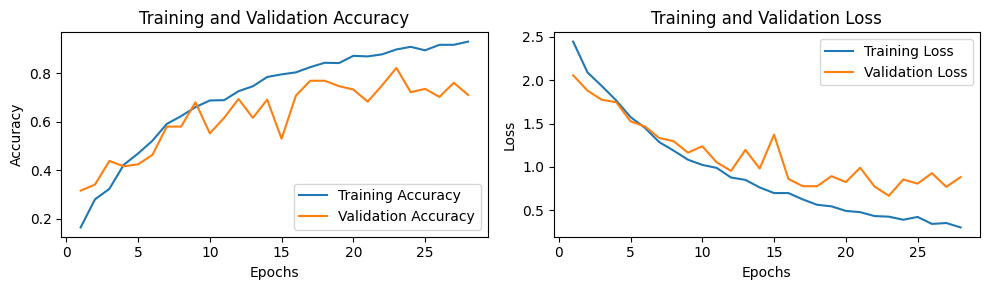

In [16]:
rmsp_optm = RMSprop(learning_rate= 0.0005)
mdl2, hist2 = rnn_train_model(features, isadam =False)
exp_res.append(plotting_train_val(hist2))
#

Epoch 1/30
14/14 - 3s - 205ms/step - accuracy: 0.1434 - loss: 2.7268 - val_accuracy: 0.2861 - val_loss: 2.1364
Epoch 2/30
14/14 - 2s - 124ms/step - accuracy: 0.1900 - loss: 2.5507 - val_accuracy: 0.2972 - val_loss: 2.0683
Epoch 3/30
14/14 - 2s - 125ms/step - accuracy: 0.2282 - loss: 2.3769 - val_accuracy: 0.3194 - val_loss: 2.0305
Epoch 4/30
14/14 - 2s - 124ms/step - accuracy: 0.2222 - loss: 2.3474 - val_accuracy: 0.3278 - val_loss: 1.9893
Epoch 5/30
14/14 - 2s - 121ms/step - accuracy: 0.2389 - loss: 2.3044 - val_accuracy: 0.3417 - val_loss: 1.9571
Epoch 6/30
14/14 - 2s - 125ms/step - accuracy: 0.2951 - loss: 2.2015 - val_accuracy: 0.3528 - val_loss: 1.9237
Epoch 7/30
14/14 - 2s - 120ms/step - accuracy: 0.2927 - loss: 2.1035 - val_accuracy: 0.3583 - val_loss: 1.8873
Epoch 8/30
14/14 - 3s - 195ms/step - accuracy: 0.2999 - loss: 2.0923 - val_accuracy: 0.3667 - val_loss: 1.8617
Epoch 9/30
14/14 - 2s - 125ms/step - accuracy: 0.3130 - loss: 2.0449 - val_accuracy: 0.3806 - val_loss: 1.8292
E

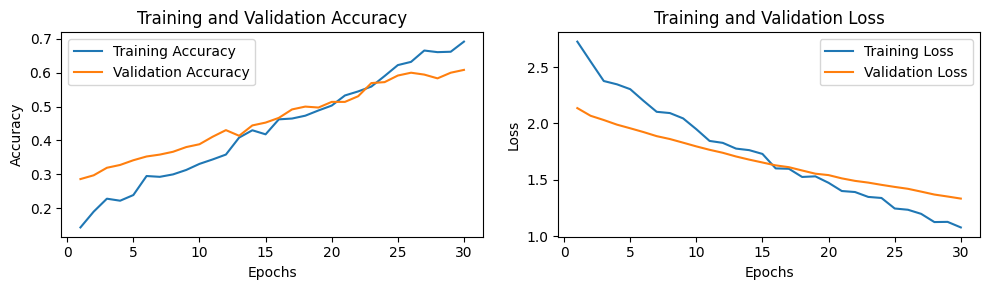

In [17]:
rmsp_optm = RMSprop(learning_rate= 0.0001)
mdl1, hist1 = cnn_train_model(features, isadam = False)
exp_res.append(plotting_train_val(hist1))
#

Epoch 1/30
14/14 - 8s - 568ms/step - accuracy: 0.1087 - loss: 2.6240 - val_accuracy: 0.1750 - val_loss: 2.3805
Epoch 2/30
14/14 - 5s - 392ms/step - accuracy: 0.1422 - loss: 2.4935 - val_accuracy: 0.2111 - val_loss: 2.3024
Epoch 3/30
14/14 - 5s - 360ms/step - accuracy: 0.1685 - loss: 2.4094 - val_accuracy: 0.2500 - val_loss: 2.2369
Epoch 4/30
14/14 - 5s - 337ms/step - accuracy: 0.1983 - loss: 2.3348 - val_accuracy: 0.2722 - val_loss: 2.1769
Epoch 5/30
14/14 - 5s - 338ms/step - accuracy: 0.2007 - loss: 2.2995 - val_accuracy: 0.2889 - val_loss: 2.1127
Epoch 6/30
14/14 - 5s - 345ms/step - accuracy: 0.2605 - loss: 2.2327 - val_accuracy: 0.3056 - val_loss: 2.0615
Epoch 7/30
14/14 - 5s - 364ms/step - accuracy: 0.2593 - loss: 2.1596 - val_accuracy: 0.3083 - val_loss: 2.0215
Epoch 8/30
14/14 - 5s - 375ms/step - accuracy: 0.2772 - loss: 2.1294 - val_accuracy: 0.3139 - val_loss: 1.9869
Epoch 9/30
14/14 - 5s - 362ms/step - accuracy: 0.2712 - loss: 2.0840 - val_accuracy: 0.3278 - val_loss: 1.9602
E

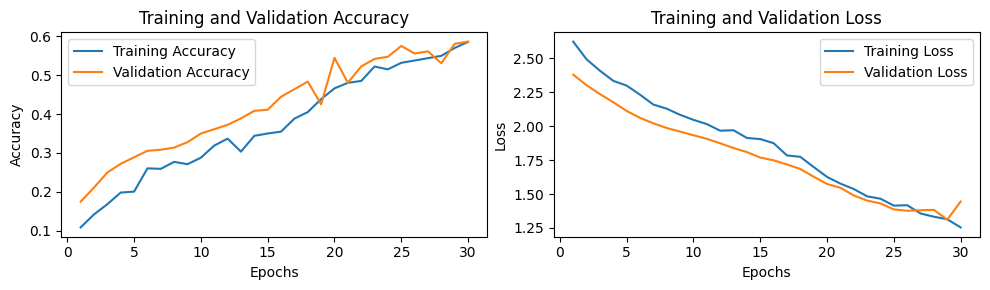

In [24]:
rmsp_optm = RMSprop(learning_rate= 0.0001)
mdl2, hist2 = rnn_train_model(features, isadam =False)
exp_res.append(plotting_train_val(hist2))
#

# هامش 

In [19]:
# the default value of the optimizers
rmsp_optm = RMSprop()
adam_optm = Adam() 
rmsp_optm.learning_rate * 1000, adam_optm.learning_rate * 1000, 

(<tf.Tensor: shape=(), dtype=float32, numpy=1.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.0>)

In [25]:
es_eps = [x[-1] for x in exp_res]
#accuracies = [f'{int(x[0]*100)}, {int(x[2]*100)}, {int(x[0]*100 - x[2]*100)}' for x in exp_res]
accuracies = [((int(x[0]*100)), (int(x[2]*100)), (int(x[0]*100 - x[2]*100))) for x in exp_res]
accuracies
#{i+1:list(v)+ [k] for i, k in enumerate(es_eps) for v in accuracies }
resdct = {i+1: list(v)+ [k] for (i, k), v in zip(enumerate(es_eps),accuracies) }
pd.DataFrame(resdct, index=['Training', 'Testing', 'Diff', 'StopInEpoch']).T

,Training,Testing,Diff,StopInEpoch
1,100,84,15,30
2,91,74,16,19
3,63,55,8,30
4,59,57,1,30
5,99,79,20,30
6,91,76,15,27
7,99,81,17,30
8,97,78,18,28
9,99,82,17,30
10,93,71,21,28


In [21]:
# Read jupyter notebook file resutls

import nbformat

def extract_results_from_notebook(notebook_path):
    # Load the notebook
    with open(notebook_path, 'r', encoding='utf-8') as f:
        notebook = nbformat.read(f, as_version=4)

    results = []

    # Iterate through each cell in the notebook
    for cell in notebook.cells:
        if cell.cell_type == 'code':
            # Check if the cell has outputs
            if cell.outputs:
                for output in cell.outputs:
                    if 'text' in output:
                        results.append(output['text'])
                    elif 'data' in output:
                        # Handle different output types (e.g., text/plain, text/html)
                        if 'text/plain' in output['data']:
                            results.append(output['data']['text/plain'])
                        elif 'text/html' in output['data']:
                            results.append(output['data']['text/html'])

    return results

notebook_file = '12_eight_Exps_Code.ipynb.ipynb' 
extracted_results = extract_results_from_notebook(notebook_file)
ep10 = 'Epoch 10/20'
acc = 'accuracy'
epall = [itm for itm in extracted_results if ep10 in itm]
epall2 = [x[x.find(ep10):] for x in epall if x.find(ep10)>=0]
all_acc = [x[x.find(acc):] for x in epall2 if x.find(acc)>=0]
all_acc

['accuracy: 0.9701 - loss: 0.3106 - val_accuracy: 0.7306 - val_loss: 0.9427\nEpoch 11/20\n14/14 - 2s - 122ms/step - accuracy: 0.9749 - loss: 0.2776 - val_accuracy: 0.7194 - val_loss: 0.9348\nEpoch 12/20\n14/14 - 2s - 121ms/step - accuracy: 0.9869 - loss: 0.2490 - val_accuracy: 0.7500 - val_loss: 0.8788\nEpoch 13/20\n14/14 - 2s - 124ms/step - accuracy: 0.9928 - loss: 0.1980 - val_accuracy: 0.7500 - val_loss: 0.8792\nEpoch 14/20\n14/14 - 2s - 123ms/step - accuracy: 0.9845 - loss: 0.1843 - val_accuracy: 0.7417 - val_loss: 0.8483\nEpoch 15/20\n14/14 - 2s - 123ms/step - accuracy: 0.9952 - loss: 0.1737 - val_accuracy: 0.7889 - val_loss: 0.8232\nEpoch 16/20\n14/14 - 2s - 126ms/step - accuracy: 0.9940 - loss: 0.1475 - val_accuracy: 0.7389 - val_loss: 0.8421\nEpoch 17/20\n14/14 - 2s - 122ms/step - accuracy: 0.9964 - loss: 0.1282 - val_accuracy: 0.7750 - val_loss: 0.7937\nEpoch 18/20\n14/14 - 2s - 124ms/step - accuracy: 0.9976 - loss: 0.1129 - val_accuracy: 0.7528 - val_loss: 0.8069\nEpoch 19/20

In [22]:
acc, tacc = 'accuracy:', 'val_accuracy:'
all_acc[0].split().index(acc), all_acc[0].split().index(tacc)
i, res = 1, {}
for ac in all_acc: 
    exp = f'CNN-{i}' if i%2 else f'RNN-{i}'
    lst = ac.split()
    i1, i2 = lst.index(acc), lst.index(tacc)
    res0 = [int(float(lst[i1+1])*100), int(float(lst[i2+1])*100), int(round(float(lst[i1+1]) - float(lst[i2+1]), 4)*100)]
    if exp in res: res[exp].extend(res0)
    else: res[exp] = res0
    i+=1
resall = pd.DataFrame(res, index=['Training Acc', 'Testing Acc', 'Acc Differences '])
resall.T

,Training Acc,Testing Acc,Acc Differences
CNN-1,97,73,23
RNN-2,83,71,11
CNN-3,34,38,-4
RNN-4,32,36,-3
CNN-5,84,63,20
RNN-6,67,69,-1
CNN-7,98,70,27
RNN-8,83,50,33
CNN-9,89,67,22
RNN-10,67,56,11
